## Imports

In [1]:
import yaml
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import argparse
from utils import get_prior
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

cudnn.benchmark = True

def delete_module(name):
    import sys
    del sys.modules[name]
    
    
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Load the config

In [3]:
config_file = './test_config.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/base/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Namespace(data=Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=16, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets'), inference=Namespace(eps='2e-5', num_points=2048, num_steps=15000, step_size_ratio=1, weight=1), log=Namespace(log_freq=1, save_dir='log/exp-test', save_freq=500, val_freq=100000, viz_freq=500), models=Namespace(criticnet=Namespace(type='small_mlp'), scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=5, epochs=25000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999,

In [4]:
cfg.data

Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=16, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets')

In [5]:
cfg.trainer

Namespace(c_iters=5, epochs=25000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1, seed=100, sigma_begin=1, sigma_end=0.01, sigma_num=10, type='trainers.ae_trainer_3D')

In [6]:
cfg.models

Namespace(criticnet=Namespace(type='small_mlp'), scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128))

In [7]:
cfg.inference

Namespace(eps='2e-5', num_points=2048, num_steps=15000, step_size_ratio=1, weight=1)

In [8]:
cfg.log

Namespace(log_freq=1, save_dir='log/exp-test', save_freq=500, val_freq=100000, viz_freq=500)

# Train

In [9]:
from scorenet import Scorenet
from critic import Criticnet, SmallMLP
from utils import get_opt, set_random_seed, exact_jacobian_trace, langevin_dynamics, visualize
from datasets.data_loader import get_data
import random
import torch.nn.utils.spectral_norm as spectral_norm

In [10]:
set_random_seed(getattr(cfg.trainer, "seed", 666))

# load data
train_data = get_data(cfg.data, 0)
#tr_pts = train_data['tr_points'].unsqueeze(0)
tr_pts = train_data['tr_points']

#te_pts = train_data['te_points'].unsqueeze(0)
te_pts = train_data['te_points']

tr_pts = tr_pts.to(device)
te_pts = te_pts.to(device)
tr_pts.requires_grad_()
te_pts.requires_grad_();

100%|██████████| 1/1 [00:00<00:00, 462.39it/s]


Total number of data:1
Min number of points: (train)2048 (test)2048


### Visualize the data

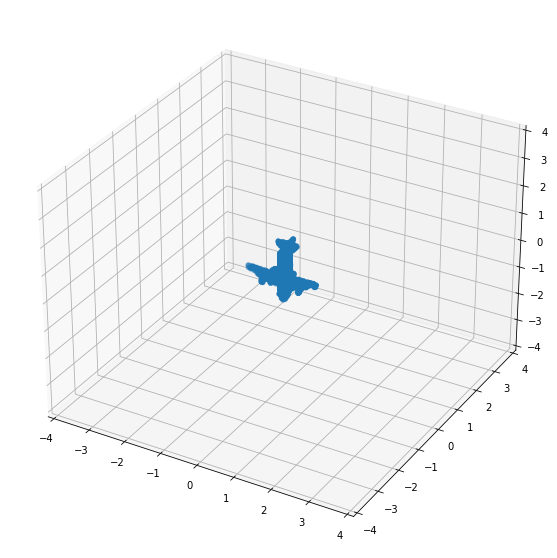

In [11]:
visualize(tr_pts)

In [12]:
# sigmas
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
print("Sigma:, ", np_sigmas)
sigmas = torch.tensor(np.array(np_sigmas)).float().to(device).view(-1, 1)

Sigma:,  [1.         0.59948425 0.35938137 0.21544347 0.12915497 0.07742637
 0.04641589 0.02782559 0.01668101 0.01      ]


In [13]:
def apply_spectral_norm(module):
    norm = nn.BatchNorm1d
    if not isinstance(module, norm) and 'weight' in module._parameters:
        spectral_norm(module)

## Both SmallMLP

In [14]:
# score net
#score_net = Scorenet()
score_net = SmallMLP(in_dim=3)
#critic_net = Criticnet()
critic_net = SmallMLP(in_dim=3)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)
SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


## Just SmallMLP CriticNet

In [15]:
critic_net = SmallMLP(in_dim=3)
score_net = Scorenet()
#critic_net = Criticnet()
#critic_net = SmallMLP(in_dim=3)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

Scorenet(
  (conv_p): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (1): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (2): ResnetBlockConv1d(
      (bn_0): BatchN

In [16]:
sigmas

tensor([[1.0000],
        [0.5995],
        [0.3594],
        [0.2154],
        [0.1292],
        [0.0774],
        [0.0464],
        [0.0278],
        [0.0167],
        [0.0100]], device='cuda:1')

In [17]:
# training
start_epoch = 0
n_epochs = 50000
print("Start epoch: %d End epoch: %d" % (start_epoch, cfg.trainer.epochs))
k_iters = 5
e_iters = 1
# for epoch in range(start_epoch, cfg.trainer.epochs):
sigmas = sigmas[-1:]

losses = []

for epoch in range(start_epoch, n_epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]
    
    score_pred = score_net(perturbed_points, sigmas)
    critic_output = critic_net(perturbed_points, sigmas)
    
    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    losses.append(loss)
    
    cycle_iter = epoch % (k_iters + e_iters)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        print("Epoch (critic) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
    else:
        loss.backward()
        opt_scorenet.step()
        print("Epoch (score) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))

Start epoch: 0 End epoch: 25000
Epoch (critic) 0 Loss=0.01473 t1=0.00613 t2=0.00860
Epoch (critic) 1 Loss=0.29044 t1=0.01969 t2=0.27076
Epoch (critic) 2 Loss=0.56720 t1=0.03248 t2=0.53472
Epoch (critic) 3 Loss=0.84729 t1=0.04451 t2=0.80277
Epoch (critic) 4 Loss=1.13318 t1=0.05595 t2=1.07724
Epoch (score) 5 Loss=1.42724 t1=0.06692 t2=1.36032
Epoch (critic) 6 Loss=0.85454 t1=-0.50576 t2=1.36030
Epoch (critic) 7 Loss=1.03396 t1=-0.60368 t2=1.63764
Epoch (critic) 8 Loss=1.21764 t1=-0.69553 t2=1.91317
Epoch (critic) 9 Loss=1.40723 t1=-0.78244 t2=2.18968
Epoch (critic) 10 Loss=1.60264 t1=-0.86668 t2=2.46932
Epoch (score) 11 Loss=1.80567 t1=-0.94835 t2=2.75402
Epoch (critic) 12 Loss=1.30044 t1=-1.45358 t2=2.75403
Epoch (critic) 13 Loss=1.46571 t1=-1.56347 t2=3.02918
Epoch (critic) 14 Loss=1.64183 t1=-1.65603 t2=3.29786
Epoch (critic) 15 Loss=1.82758 t1=-1.73553 t2=3.56311
Epoch (critic) 16 Loss=2.02241 t1=-1.80564 t2=3.82805
Epoch (score) 17 Loss=2.22679 t1=-1.86875 t2=4.09554
Epoch (critic) 

Epoch (critic) 151 Loss=16.35376 t1=-20.21119 t2=36.56495
Epoch (critic) 152 Loss=16.62597 t1=-20.17926 t2=36.80523
Epoch (critic) 153 Loss=16.81189 t1=-20.22778 t2=37.03967
Epoch (critic) 154 Loss=16.96304 t1=-20.22388 t2=37.18693
Epoch (score) 155 Loss=17.07930 t1=-20.24467 t2=37.32397
Epoch (critic) 156 Loss=16.46215 t1=-20.89427 t2=37.35642
Epoch (critic) 157 Loss=16.63606 t1=-20.81830 t2=37.45437
Epoch (critic) 158 Loss=16.77957 t1=-20.69477 t2=37.47433
Epoch (critic) 159 Loss=16.94466 t1=-20.56107 t2=37.50574
Epoch (critic) 160 Loss=17.09215 t1=-20.34938 t2=37.44153
Epoch (score) 161 Loss=17.08595 t1=-20.30346 t2=37.38940
Epoch (critic) 162 Loss=16.75434 t1=-20.64941 t2=37.40375
Epoch (critic) 163 Loss=16.74258 t1=-20.54171 t2=37.28428
Epoch (critic) 164 Loss=16.82346 t1=-20.36300 t2=37.18647
Epoch (critic) 165 Loss=16.92195 t1=-20.12185 t2=37.04380
Epoch (critic) 166 Loss=16.99590 t1=-19.93652 t2=36.93242
Epoch (score) 167 Loss=17.04761 t1=-19.72549 t2=36.77310
Epoch (critic) 16

Epoch (critic) 304 Loss=23.65207 t1=-27.88503 t2=51.53710
Epoch (score) 305 Loss=23.35007 t1=-28.01554 t2=51.36561
Epoch (critic) 306 Loss=21.09249 t1=-30.27995 t2=51.37244
Epoch (critic) 307 Loss=21.21124 t1=-29.50272 t2=50.71395
Epoch (critic) 308 Loss=21.83489 t1=-28.56958 t2=50.40447
Epoch (critic) 309 Loss=21.50941 t1=-28.63206 t2=50.14147
Epoch (critic) 310 Loss=21.74273 t1=-28.46362 t2=50.20634
Epoch (score) 311 Loss=22.51394 t1=-27.85718 t2=50.37112
Epoch (critic) 312 Loss=21.95953 t1=-28.38271 t2=50.34224
Epoch (critic) 313 Loss=22.46453 t1=-28.13848 t2=50.60301
Epoch (critic) 314 Loss=23.10307 t1=-27.93180 t2=51.03487
Epoch (critic) 315 Loss=24.01318 t1=-27.64932 t2=51.66250
Epoch (critic) 316 Loss=25.17461 t1=-27.04874 t2=52.22335
Epoch (score) 317 Loss=25.69995 t1=-26.97989 t2=52.67984
Epoch (critic) 318 Loss=24.41275 t1=-28.21436 t2=52.62712
Epoch (critic) 319 Loss=25.23045 t1=-28.02910 t2=53.25955
Epoch (critic) 320 Loss=25.53885 t1=-28.24385 t2=53.78270
Epoch (critic) 32

Epoch (score) 455 Loss=31.27485 t1=-32.78596 t2=64.06082
Epoch (critic) 456 Loss=30.23612 t1=-33.77417 t2=64.01028
Epoch (critic) 457 Loss=30.66199 t1=-33.16155 t2=63.82354
Epoch (critic) 458 Loss=31.32356 t1=-32.17196 t2=63.49552
Epoch (critic) 459 Loss=31.53087 t1=-31.75164 t2=63.28251
Epoch (critic) 460 Loss=31.96352 t1=-31.48258 t2=63.44609
Epoch (score) 461 Loss=32.07123 t1=-31.69518 t2=63.76641
Epoch (critic) 462 Loss=31.66982 t1=-32.00061 t2=63.67043
Epoch (critic) 463 Loss=31.03151 t1=-33.61180 t2=64.64331
Epoch (critic) 464 Loss=31.97445 t1=-33.70877 t2=65.68322
Epoch (critic) 465 Loss=32.81403 t1=-33.84829 t2=66.66232
Epoch (critic) 466 Loss=33.88332 t1=-33.49065 t2=67.37398
Epoch (score) 467 Loss=34.26410 t1=-33.66677 t2=67.93087
Epoch (critic) 468 Loss=32.40697 t1=-35.78703 t2=68.19400
Epoch (critic) 469 Loss=32.89360 t1=-35.02521 t2=67.91881
Epoch (critic) 470 Loss=33.54641 t1=-33.99189 t2=67.53830
Epoch (critic) 471 Loss=33.84074 t1=-33.33653 t2=67.17728
Epoch (critic) 47

Epoch (critic) 609 Loss=69.90492 t1=-31.37856 t2=101.28348
Epoch (critic) 610 Loss=70.98862 t1=-32.15184 t2=103.14046
Epoch (score) 611 Loss=70.90926 t1=-32.64894 t2=103.55820
Epoch (critic) 612 Loss=69.79816 t1=-34.65717 t2=104.45534
Epoch (critic) 613 Loss=68.43098 t1=-34.67535 t2=103.10632
Epoch (critic) 614 Loss=70.99966 t1=-28.70032 t2=99.69997
Epoch (critic) 615 Loss=71.08191 t1=-27.41251 t2=98.49443
Epoch (critic) 616 Loss=72.55563 t1=-24.98677 t2=97.54240
Epoch (score) 617 Loss=72.96278 t1=-25.43093 t2=98.39371
Epoch (critic) 618 Loss=69.97229 t1=-28.85878 t2=98.83107
Epoch (critic) 619 Loss=70.68530 t1=-29.78308 t2=100.46837
Epoch (critic) 620 Loss=72.66992 t1=-30.30563 t2=102.97556
Epoch (critic) 621 Loss=72.90360 t1=-32.68640 t2=105.59000
Epoch (critic) 622 Loss=74.72253 t1=-31.23155 t2=105.95407
Epoch (score) 623 Loss=75.95831 t1=-29.63104 t2=105.58935
Epoch (critic) 624 Loss=70.59889 t1=-34.21752 t2=104.81641
Epoch (critic) 625 Loss=73.14583 t1=-31.40401 t2=104.54985
Epoch

Epoch (critic) 758 Loss=126.79676 t1=-36.60110 t2=163.39787
Epoch (critic) 759 Loss=126.51479 t1=-38.50640 t2=165.02119
Epoch (critic) 760 Loss=131.21017 t1=-39.06985 t2=170.28003
Epoch (score) 761 Loss=134.94751 t1=-36.91783 t2=171.86534
Epoch (critic) 762 Loss=126.06752 t1=-45.47850 t2=171.54602
Epoch (critic) 763 Loss=129.96762 t1=-43.48856 t2=173.45618
Epoch (critic) 764 Loss=130.21559 t1=-44.83746 t2=175.05305
Epoch (critic) 765 Loss=130.51126 t1=-47.47843 t2=177.98969
Epoch (critic) 766 Loss=133.29266 t1=-48.85616 t2=182.14880
Epoch (score) 767 Loss=131.92950 t1=-51.23495 t2=183.16446
Epoch (critic) 768 Loss=129.38063 t1=-53.09114 t2=182.47177
Epoch (critic) 769 Loss=129.08163 t1=-54.19522 t2=183.27686
Epoch (critic) 770 Loss=132.89990 t1=-49.71226 t2=182.61215
Epoch (critic) 771 Loss=129.04735 t1=-51.71597 t2=180.76331
Epoch (critic) 772 Loss=134.89799 t1=-47.22167 t2=182.11966
Epoch (score) 773 Loss=136.39560 t1=-48.21805 t2=184.61365
Epoch (critic) 774 Loss=126.71344 t1=-57.33

Epoch (critic) 896 Loss=158.49428 t1=-67.43706 t2=225.93134
Epoch (critic) 897 Loss=164.73135 t1=-66.34962 t2=231.08098
Epoch (critic) 898 Loss=165.17999 t1=-61.55776 t2=226.73776
Epoch (score) 899 Loss=161.94936 t1=-68.69771 t2=230.64706
Epoch (critic) 900 Loss=162.76761 t1=-72.11897 t2=234.88658
Epoch (critic) 901 Loss=162.23499 t1=-66.25316 t2=228.48814
Epoch (critic) 902 Loss=169.81593 t1=-62.79571 t2=232.61166
Epoch (critic) 903 Loss=168.21445 t1=-61.93747 t2=230.15192
Epoch (critic) 904 Loss=173.02037 t1=-57.95144 t2=230.97180
Epoch (score) 905 Loss=176.90822 t1=-54.51080 t2=231.41901
Epoch (critic) 906 Loss=164.11388 t1=-64.19339 t2=228.30725
Epoch (critic) 907 Loss=168.37366 t1=-60.41913 t2=228.79279
Epoch (critic) 908 Loss=162.57147 t1=-62.41750 t2=224.98895
Epoch (critic) 909 Loss=173.09801 t1=-56.90131 t2=229.99931
Epoch (critic) 910 Loss=166.92535 t1=-58.47279 t2=225.39813
Epoch (score) 911 Loss=170.14838 t1=-56.28107 t2=226.42944
Epoch (critic) 912 Loss=165.68204 t1=-62.99

Epoch (critic) 1035 Loss=189.37636 t1=-89.29976 t2=278.67612
Epoch (critic) 1036 Loss=186.67850 t1=-88.42130 t2=275.09979
Epoch (score) 1037 Loss=181.51660 t1=-94.47063 t2=275.98721
Epoch (critic) 1038 Loss=188.01749 t1=-87.45512 t2=275.47260
Epoch (critic) 1039 Loss=182.45744 t1=-89.42796 t2=271.88538
Epoch (critic) 1040 Loss=192.65979 t1=-78.94154 t2=271.60132
Epoch (critic) 1041 Loss=197.60011 t1=-74.40423 t2=272.00433
Epoch (critic) 1042 Loss=202.66118 t1=-64.39234 t2=267.05353
Epoch (score) 1043 Loss=194.74800 t1=-67.21477 t2=261.96277
Epoch (critic) 1044 Loss=186.49718 t1=-79.84605 t2=266.34320
Epoch (critic) 1045 Loss=193.51494 t1=-73.33775 t2=266.85269
Epoch (critic) 1046 Loss=178.29613 t1=-80.90282 t2=259.19897
Epoch (critic) 1047 Loss=182.92911 t1=-78.04411 t2=260.97321
Epoch (critic) 1048 Loss=179.68259 t1=-85.40083 t2=265.08344
Epoch (score) 1049 Loss=175.96587 t1=-89.72501 t2=265.69089
Epoch (critic) 1050 Loss=173.08081 t1=-100.57860 t2=273.65942
Epoch (critic) 1051 Loss=1

Epoch (critic) 1172 Loss=242.40211 t1=-26.92682 t2=269.32892
Epoch (critic) 1173 Loss=246.26782 t1=-27.15616 t2=273.42398
Epoch (critic) 1174 Loss=244.48761 t1=-21.12241 t2=265.61002
Epoch (score) 1175 Loss=238.32660 t1=-24.07371 t2=262.40033
Epoch (critic) 1176 Loss=238.13571 t1=-24.39083 t2=262.52652
Epoch (critic) 1177 Loss=255.11639 t1=-14.23326 t2=269.34967
Epoch (critic) 1178 Loss=255.85526 t1=-13.12331 t2=268.97858
Epoch (critic) 1179 Loss=257.78717 t1=-6.50555 t2=264.29269
Epoch (critic) 1180 Loss=257.24927 t1=-8.05511 t2=265.30435
Epoch (score) 1181 Loss=258.23303 t1=-11.63989 t2=269.87292
Epoch (critic) 1182 Loss=258.08417 t1=-17.08511 t2=275.16925
Epoch (critic) 1183 Loss=263.66293 t1=-10.26791 t2=273.93085
Epoch (critic) 1184 Loss=263.98871 t1=-9.00742 t2=272.99612
Epoch (critic) 1185 Loss=268.34253 t1=-9.99001 t2=278.33252
Epoch (critic) 1186 Loss=263.16193 t1=-10.16048 t2=273.32245
Epoch (score) 1187 Loss=269.03772 t1=-3.36579 t2=272.40350
Epoch (critic) 1188 Loss=269.542

KeyboardInterrupt: 

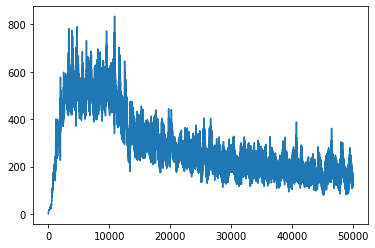

In [18]:
plt.plot(losses);

In [27]:
pt_cl, pt_cl_list = langevin_dynamics(score_net, sigmas, eps=0.00001, num_steps=15000)

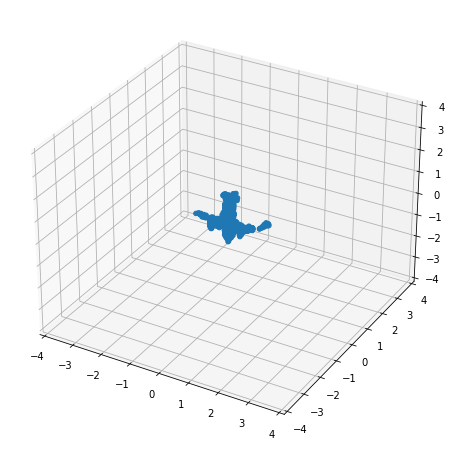

In [28]:
# Visualization
from mpl_toolkits.mplot3d import Axes3D
#for pt_cl_item in pt_cl_list:
#    visualize(pt_cl_item)
#visualize(pt_cl_item)
visualize(pt_cl_list[-1])

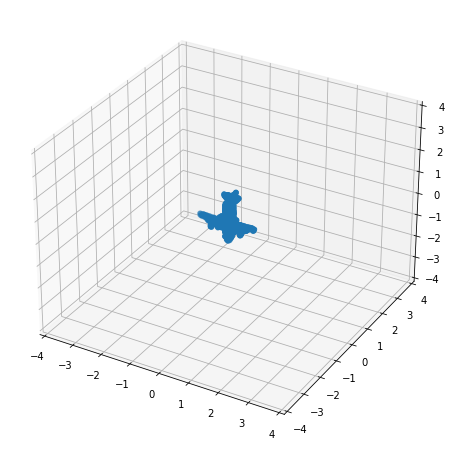

In [21]:
visualize(tr_pts)

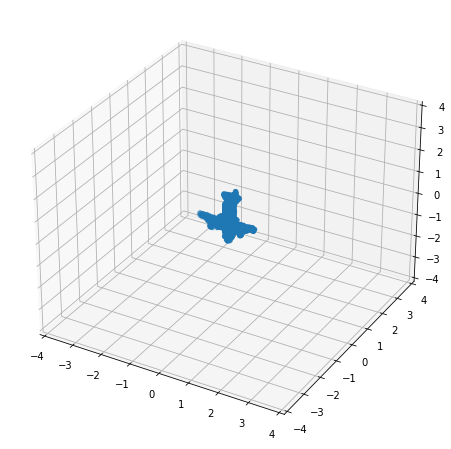

In [22]:
visualize(perturbed_points)